In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymc as pm
import numpyro
numpyro.set_platform("cpu")
numpyro.set_host_device_count(16)
import numpy as np
import pytensor.tensor as pt
import xarray as xr
import pandas as pd
from foottraffic import FoottrafficModel

In [3]:
model = FoottrafficModel.load("../complex_model")

In [4]:
model.fit(draws=1000, tune=1000, cores=4, nuts_sampler='numpyro')

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 45 divergences after tuning. Increase `target_accept` or reparameterize.


In [6]:
constant_data = model.trace.constant_data

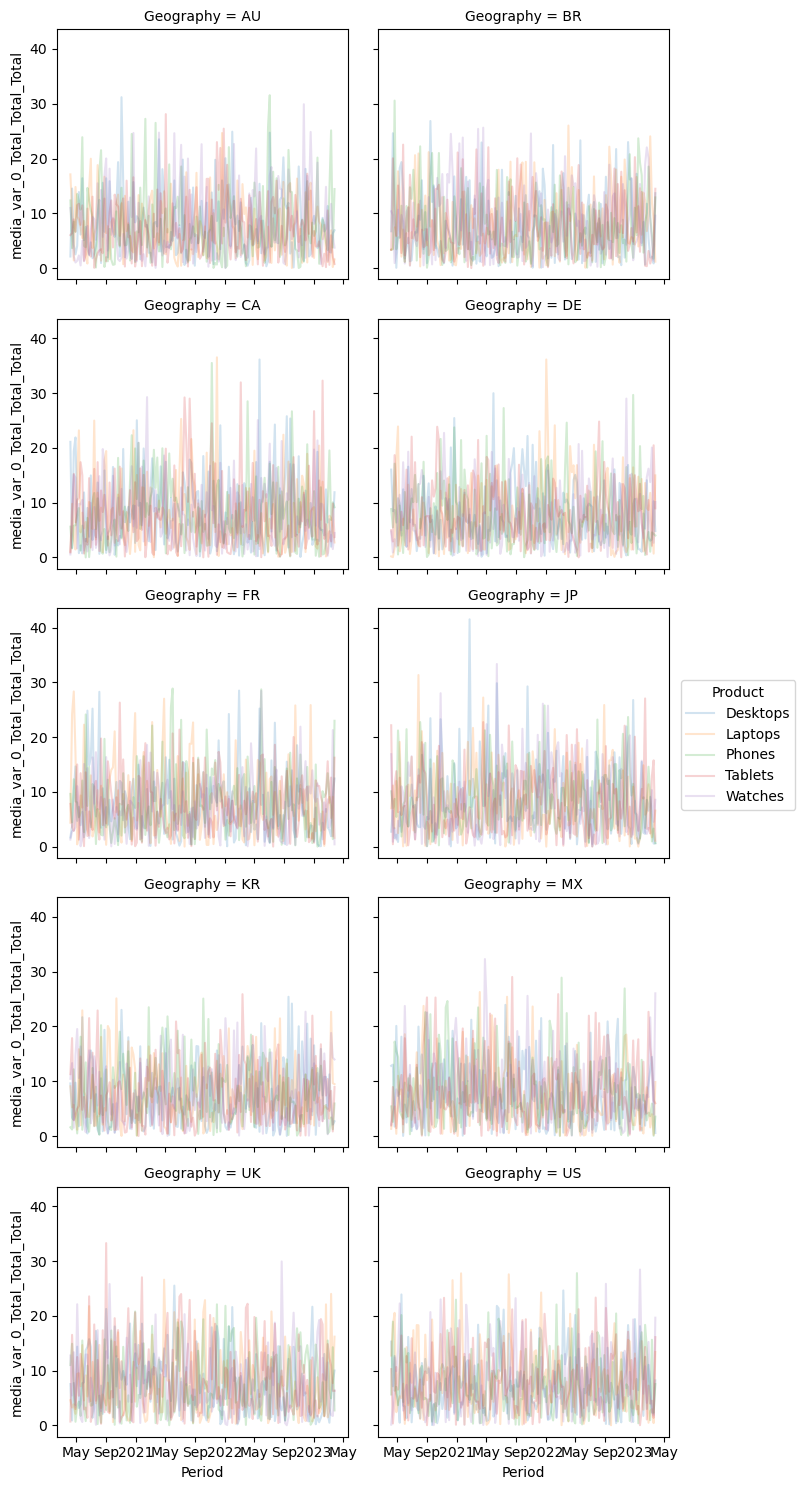

In [10]:
constant_data.media_var_0_Total_Total_Total.plot.line(x='Period', hue="Product", col='Geography', col_wrap=2, alpha=.2)

In [13]:
[var.variable_name for var in model.return_media_variables()]

['media_var_0_Total_Total_Total']

In [5]:

model.predict(subset={"chain": slice(0,1), "draw": slice(0,1000, 5)})

Output()

<xarray.Dataset> Size: 200MB
Dimensions:                                        (chain: 2, draw: 200,
                                                    Geography: 10, Product: 5,
                                                    Period: 156)
Coordinates:
  * chain                                          (chain) int64 16B 0 1
  * draw                                           (draw) int64 2kB 0 1 ... 199
  * Geography                                      (Geography) <U2 80B 'AU' ....
  * Product                                        (Product) <U8 160B 'Deskto...
  * Period                                         (Period) datetime64[ns] 1kB ...
Data variables: (12/13)
    Promotion_Total_Total_Total_coeff_estimate     (chain, draw, Geography, Product) float64 160kB ...
    Promotion_Total_Total_Total_contribution       (chain, draw, Geography, Product, Period) float64 25MB ...
    Promotion_Total_Total_Total_transformed        (chain, draw, Geography, Product, Period) float64 25MB ...
    intercept_coeff_estimate                       (chain, draw, Geography, Product) float64 160kB ...
    intercept_contribution                         (chain, draw, Geography, Product, Period) float64 25MB ...
    media_var_0_Total_Total_Total_K                (chain, draw) float64 3kB ...
    ...                                             ...
    media_var_0_Total_Total_Total_coeff_estimate   (chain, draw, Geography, Product) float64 160kB ...
    media_var_0_Total_Total_Total_contribution     (chain, draw, Geography, Product, Period) float64 25MB ...
    media_var_0_Total_Total_Total_media_transform  (chain, draw, Geography, Product, Period) float64 25MB ...
    media_var_0_Total_Total_Total_n                (chain, draw) float64 3kB ...
    media_var_0_Total_Total_Total_transformed      (chain, draw, Geography, Product, Period) float64 25MB ...
    mu                                             (chain, draw, Geography, Product, Period) float64 25MB ...
Attributes:
    created_at:                 2024-10-19T20:28:53.699388+00:00
    arviz_version:              0.19.0
    inference_library:          pymc
    inference_library_version:  5.16.2

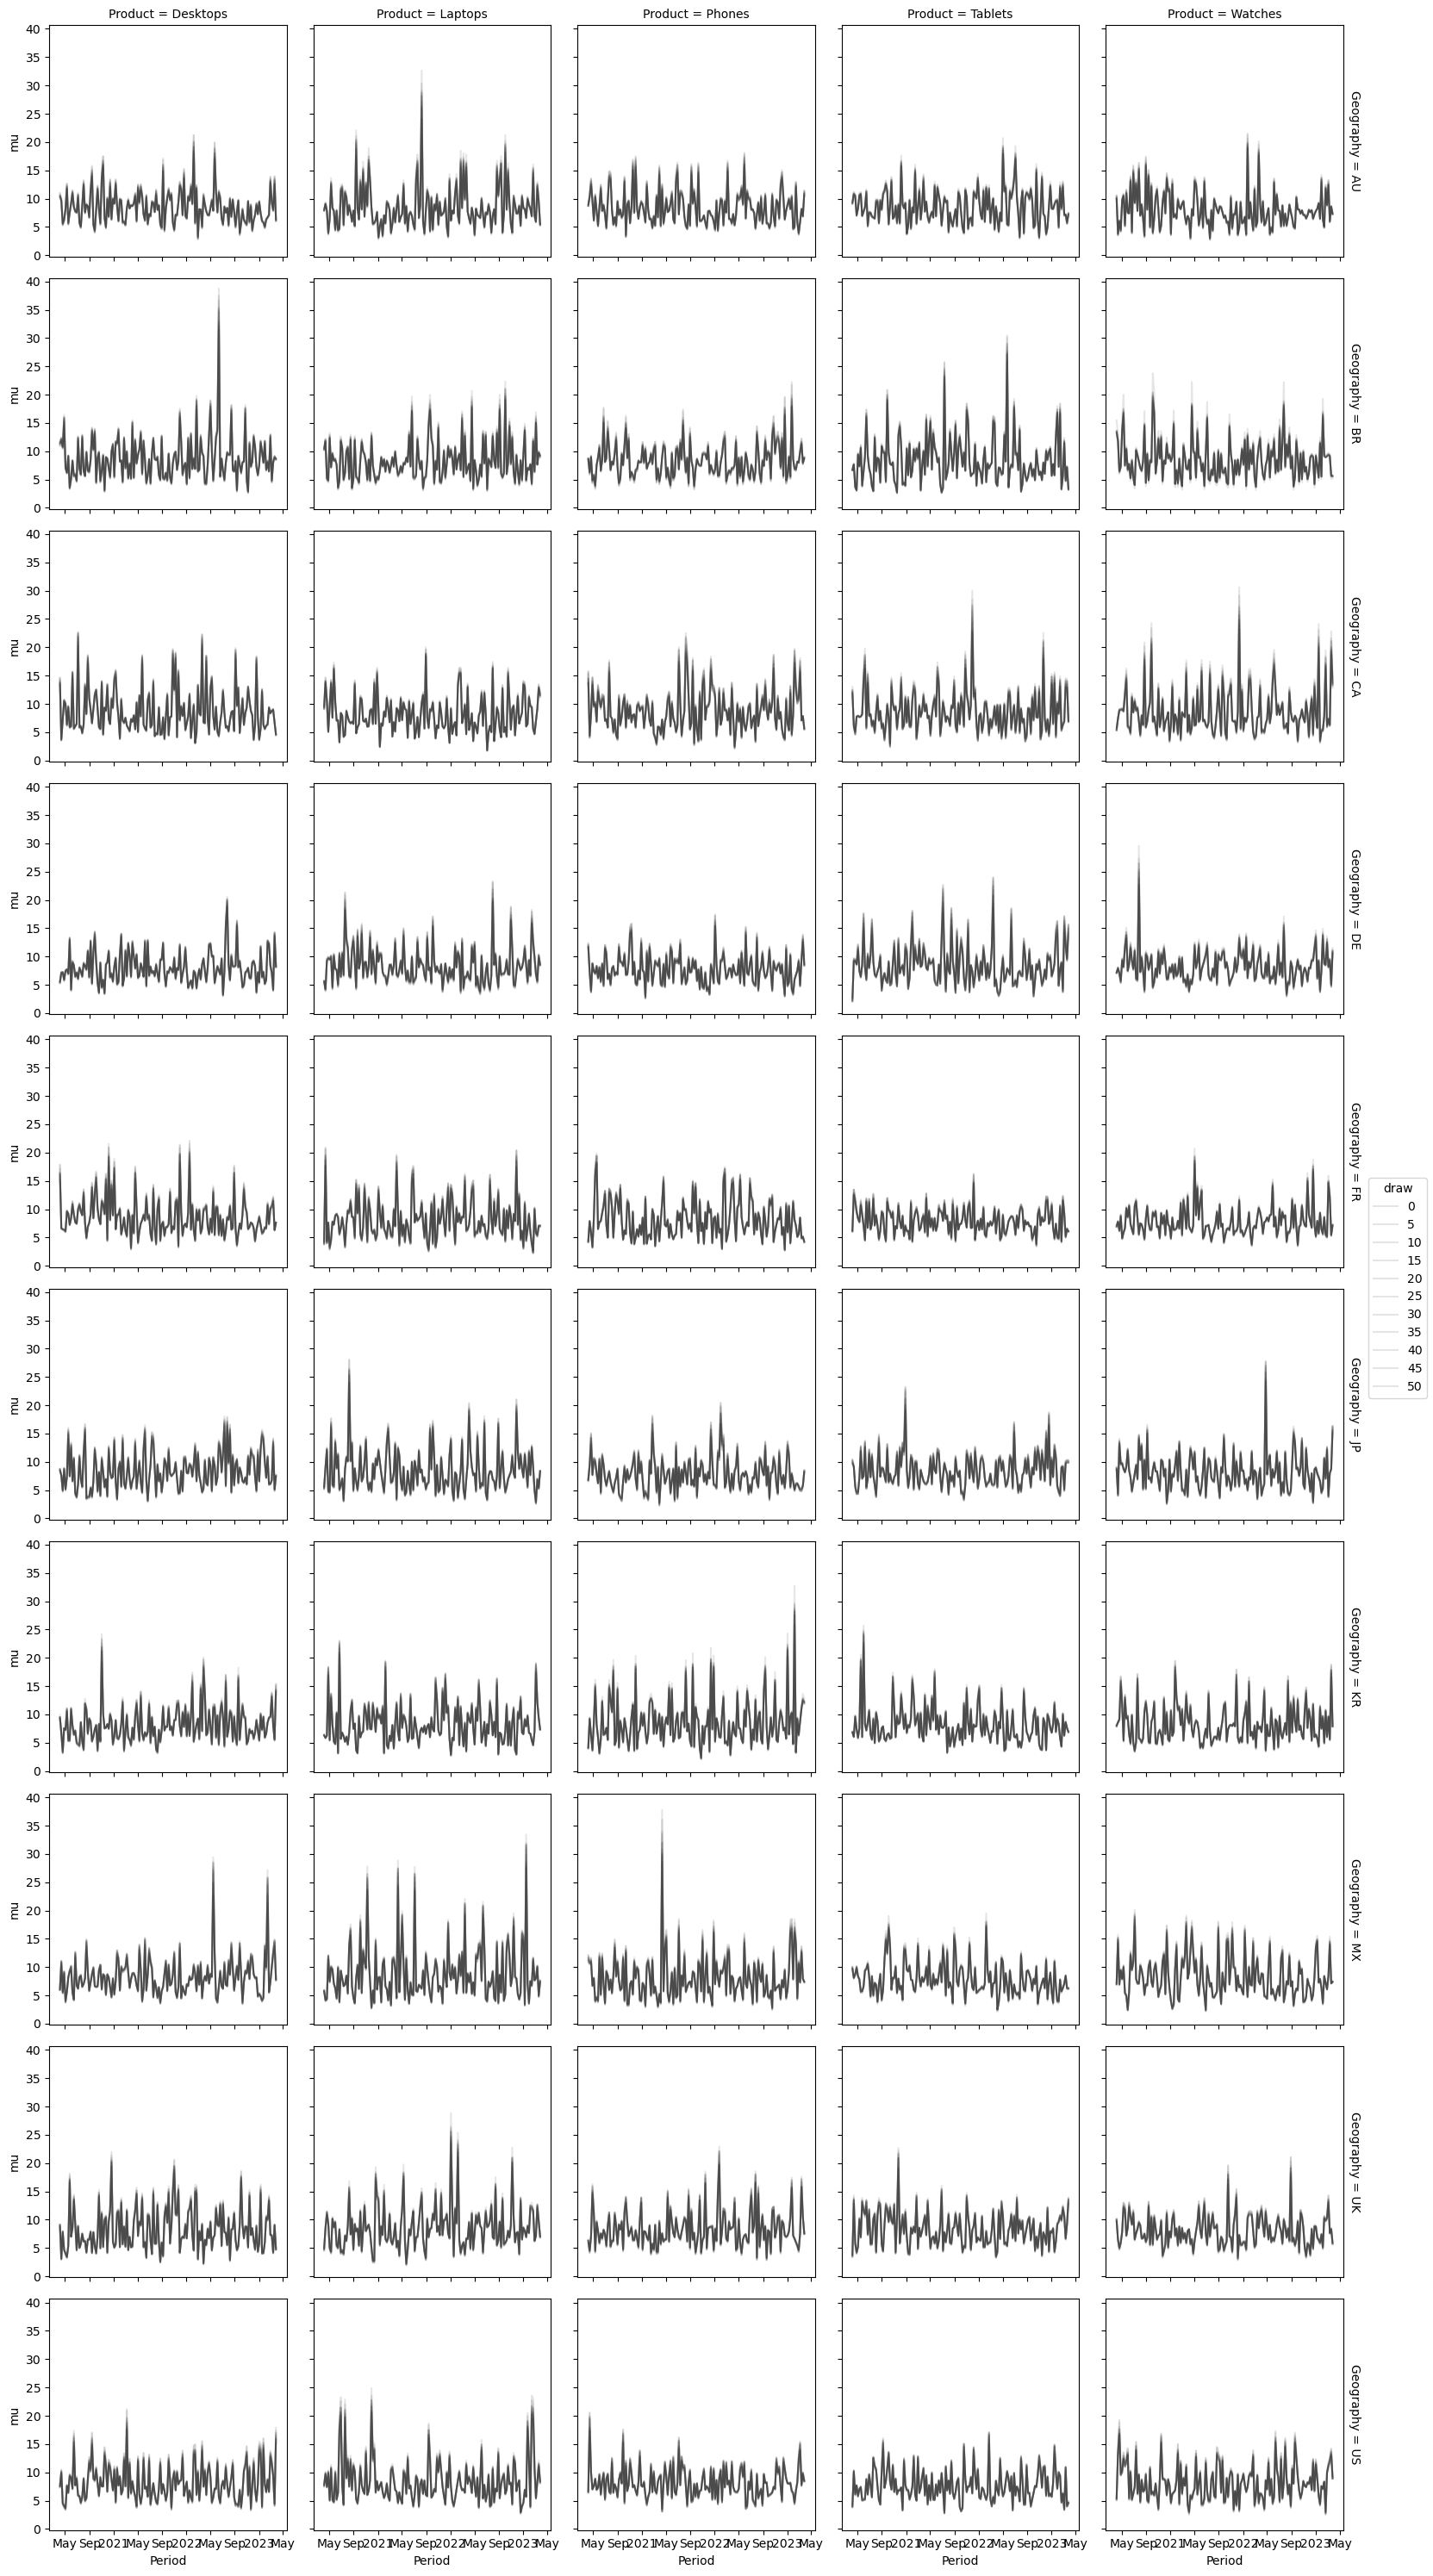

In [8]:
model.trace.posterior.mu.sel(chain=0, draw=slice(0,50, 5)).plot(x="Period", col="Product", row="Geography", hue="draw", color='k', alpha=0.1)

In [44]:
data = xr.DataArray(
  np.random.geometric(0.5, size=(50, 156)) - 1,
  coords=[('geographies', np.arange(50)), ('date', pd.date_range('2021-01-01', periods=156, freq='W-MON'))],
  dims=['geographies', 'date'])
data

<xarray.DataArray (geographies: 50, date: 156)> Size: 62kB
array([[ 0, 11,  2, ...,  1,  2,  0],
       [ 0,  3,  0, ...,  2,  0,  2],
       [ 2,  0,  1, ...,  0,  3,  2],
       ...,
       [ 1,  0,  2, ...,  5,  1,  0],
       [ 1,  0,  0, ...,  0,  2,  1],
       [ 2,  0,  3, ...,  0,  1,  4]])
Coordinates:
  * geographies  (geographies) int64 400B 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
  * date         (date) datetime64[ns] 1kB 2021-01-04 2021-01-11 ... 2023-12-25

In [45]:
data.coords.items()

ItemsView(Coordinates:
  * geographies  (geographies) int64 400B 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
  * date         (date) datetime64[ns] 1kB 2021-01-04 2021-01-11 ... 2023-12-25)

In [46]:

with pm.Model(coords = {k: v for k, v in data.coords.items()}) as model:
    constant_data = pm.Data('constant_data', data, dims=data.dims)
    
  
    

In [73]:
xr.Dataset.from_dataframe(data.to_dataframe("Geom"))

<xarray.Dataset> Size: 64kB
Dimensions:      (geographies: 50, date: 156)
Coordinates:
  * geographies  (geographies) int64 400B 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49
  * date         (date) datetime64[ns] 1kB 2021-01-04 2021-01-11 ... 2023-12-25
Data variables:
    Geom         (geographies, date) int64 62kB 0 11 2 0 0 0 2 ... 0 1 0 0 0 1 4

In [69]:
data.where(data > 0).median(dim='date')

<xarray.DataArray (geographies: 50)> Size: 400B
array([2. , 1. , 1. , 2. , 2. , 2. , 1. , 1. , 2. , 2. , 1. , 2. , 1.5,
       2. , 2. , 1. , 1. , 2. , 2. , 1.5, 1. , 1. , 1. , 2. , 2. , 2. ,
       1. , 1. , 1. , 2. , 2. , 2. , 2. , 1. , 1. , 1. , 1. , 2. , 1.5,
       1. , 2. , 1. , 2. , 2. , 1. , 2. , 1. , 2. , 1. , 2. ])
Coordinates:
  * geographies  (geographies) int64 400B 0 1 2 3 4 5 6 ... 43 44 45 46 47 48 49

In [15]:
contritributions = model.get_contributions()

In [59]:
(constant_data.sum(axis=-1)/((constant_data>0).sum(axis=-1).clip(1, np.inf))).eval().shape

(50,)

In [ ]:
base_variables = 